# Dataset

Dataset url : https://www.kaggle.com/datasets/charuchaudhry/plantvillage-tomato-leaf-dataset

Only using 3 sub classes: ['Tomato___healthy','Tomato___Early_blight','Tomato___Late_blight']


In [142]:
file_path='/0Learning/AI-ML-Specialist/datasets/tomato-disease.zip'

In [143]:
from google.colab import drive
import zipfile
import os

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path to the ZIP file in Google Drive
zip_path = '/content/drive/My Drive'+file_path  # Update this path

# Step 3: Extract the ZIP file to /data directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [144]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch

In [145]:
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images organized in subfolders
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.root_dir = root_dir
        self.transform = transform
        # self.classes = sorted(os.listdir(root_dir))
        self.classes = ['Tomato___healthy','Tomato___Early_blight','Tomato___Late_blight']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.image_paths = []
        self.labels = []

        # Collect all image paths and their corresponding labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [146]:
data_dir = "./data/tomato-disease"
batch_size = 32
seed=42
train_split = 0.7
val_split = 0.15

## Splitting data into training and testing sets

In [147]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [148]:
# Define transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
# ])

data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create dataset
full_dataset = ImageFolderDataset(data_dir, transform=data_augmentation)


# Calculate lengths for splits
total_size = len(full_dataset)
train_size = int(train_split * total_size)
val_size = int(val_split * total_size)
test_size = total_size - train_size - val_size

# Split dataset
torch.manual_seed(seed)
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 # use 4 for training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

classes = full_dataset.classes
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 79
Validation batches: 17
Test batches: 17


In [149]:
# Print the size of the augmented training dataset
print(f"Size of augmented training dataset: {len(train_dataset)}")

Size of augmented training dataset: 2520


In [150]:
print("classes:",classes)

classes: ['Tomato___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight']


# Bulding Model

In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [152]:
class TomatoDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=10,dropout_rate=0.25):
        super(TomatoDiseaseClassifier, self).__init__()

        # Custom convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            # First convolutional layer
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            # Second convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),

            # # Third convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),
        )

        # Custom convolutional layers
        self.fc_layers = nn.Sequential(
            # Fully connected layers
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, 3)  # Output layer for 10 classes
        )

    def forward(self, x):
        conv_out = self.conv_layers(x)
        fc_in = conv_out.view(conv_out.size(0), -1)
        logits= self.fc_layers(fc_in)
        return logits
        # return conv_out

In [153]:
class OptimizedClassifier(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.2):
        super(OptimizedClassifier, self).__init__()

        # First block - Input processing (3 channels -> 64)
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )

        # Second block - Feature extraction (64 -> 128)
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )

        # Third block - Deep features (128 -> 256)
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature extraction
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        # Global average pooling
        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        # # Classification
        x = self.classifier(x)
        return x

In [154]:
model = OptimizedClassifier(num_classes=len(full_dataset.classes))
model.to(device)


OptimizedClassifier(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2

In [155]:
# x = torch.randn(1, 3, 224, 224)
# x = x.to(device)
# print("input shape:",x.shape)
# model(x).shape

In [156]:
# using sample from the dataset
x,y = full_dataset[0]
print("x:",x.shape)
x = x.unsqueeze(0)
print("x in the batch",x.shape)
print("y value: ", y)

# crate one hot encoded vector for y
y_vect = torch.zeros(len(classes), dtype=torch.float32)
y_vect[y] = 1.0

x = x.to(device)
print("y_vect:",y_vect.shape)
logits = model(x)
print("prediction:",logits.shape)

prediction_vect = torch.softmax(logits, dim=1)
print("prediction_vect:",prediction_vect.shape)

predicted_label = torch.argmax(prediction_vect)
print("predicted_label:",predicted_label)

x: torch.Size([3, 224, 224])
x in the batch torch.Size([1, 3, 224, 224])
y value:  0
y_vect: torch.Size([3])
prediction: torch.Size([1, 3])
prediction_vect: torch.Size([1, 3])
predicted_label: tensor(0, device='cuda:0')


# Initialize model

In [157]:
model = OptimizedClassifier(num_classes=len(full_dataset.classes))
model = model.to(device)

# Print model architecture

In [158]:
#model.state_dict()

In [159]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
block1.0.weight 	 torch.Size([64, 3, 3, 3])
block1.0.bias 	 torch.Size([64])
block1.1.weight 	 torch.Size([64])
block1.1.bias 	 torch.Size([64])
block1.1.running_mean 	 torch.Size([64])
block1.1.running_var 	 torch.Size([64])
block1.1.num_batches_tracked 	 torch.Size([])
block1.3.weight 	 torch.Size([64, 64, 3, 3])
block1.3.bias 	 torch.Size([64])
block1.4.weight 	 torch.Size([64])
block1.4.bias 	 torch.Size([64])
block1.4.running_mean 	 torch.Size([64])
block1.4.running_var 	 torch.Size([64])
block1.4.num_batches_tracked 	 torch.Size([])
block2.0.weight 	 torch.Size([128, 64, 3, 3])
block2.0.bias 	 torch.Size([128])
block2.1.weight 	 torch.Size([128])
block2.1.bias 	 torch.Size([128])
block2.1.running_mean 	 torch.Size([128])
block2.1.running_var 	 torch.Size([128])
block2.1.num_batches_tracked 	 torch.Size([])
block2.3.weight 	 torch.Size([128, 128, 3, 3])
block2.3.bias 	 torch.Size([128])
block2.4.weight 	 torch.Size([128])
block2.4.bias 	 torch.Size([128])
block

In [160]:
# Use Adam optimizer with L2 regularization (weight decay)
# optimizer = optim.Adam(
#     model.parameters(), lr=0.1, weight_decay=0.01
# )

optimizer = optim.Adam( model.parameters(), lr=0.01, weight_decay=0.01)


# Loss function
criterion = nn.CrossEntropyLoss()

In [161]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        batch_idx=0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # print("input shape:", inputs.shape)
            # print("label shape:", labels.shape)
            # print("label:", labels)

            # Forward pass
            logits = model(inputs)
            # Calculate loss
            loss = criterion(logits, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()

            prediction_vect = torch.softmax(logits, dim=1)
            # print("prediction_vect:",prediction_vect.shape)

            predicted_labels = torch.argmax(prediction_vect, dim=1)
            # print("predicted_labels:",predicted_labels.shape)
            # print("predicted_labels:",predicted_labels)
            # print("actual labels:",labels)

            total += labels.size(0)
            correct += (predicted_labels == labels).sum().item()
            # print("correct:",correct)
            # print("total:",total)
            # Optional: Print batch progress
            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')
            batch_idx+=1

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                logits = model(inputs)
                loss = criterion(logits, labels)

                running_loss += loss.item()

                prediction_vect = torch.softmax(logits, dim=1)
                predicted_labels = torch.argmax(prediction_vect, dim=1)

                total += labels.size(0)
                correct += (predicted_labels == labels).sum().item()

        epoch_val_loss = running_loss / len(val_loader)
        epoch_val_acc = 100. * correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [162]:
# Train the model
print("Starting training...")
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=30, device=device
)


Starting training...

Epoch 1/30:
Train Loss: 2.9313, Train Acc: 44.56%
Val Loss: 1.1319, Val Acc: 38.15%

Epoch 2/30:
Train Loss: 0.9551, Train Acc: 55.71%
Val Loss: 1.6212, Val Acc: 36.30%

Epoch 3/30:
Train Loss: 0.8850, Train Acc: 59.60%
Val Loss: 1.1233, Val Acc: 49.81%

Epoch 4/30:
Train Loss: 0.8071, Train Acc: 64.29%
Val Loss: 0.9539, Val Acc: 54.26%

Epoch 5/30:
Train Loss: 0.7877, Train Acc: 66.07%
Val Loss: 0.8225, Val Acc: 68.89%

Epoch 6/30:
Train Loss: 0.6866, Train Acc: 69.88%
Val Loss: 0.7897, Val Acc: 62.78%

Epoch 7/30:
Train Loss: 0.7070, Train Acc: 68.65%
Val Loss: 0.8489, Val Acc: 62.22%

Epoch 8/30:
Train Loss: 0.6796, Train Acc: 70.04%
Val Loss: 0.7480, Val Acc: 65.19%

Epoch 9/30:
Train Loss: 0.6785, Train Acc: 70.24%
Val Loss: 0.7564, Val Acc: 66.11%

Epoch 10/30:
Train Loss: 0.6979, Train Acc: 69.40%
Val Loss: 1.1081, Val Acc: 55.56%

Epoch 11/30:
Train Loss: 0.6936, Train Acc: 69.01%
Val Loss: 0.9016, Val Acc: 64.26%

Epoch 12/30:
Train Loss: 0.6964, Train Ac

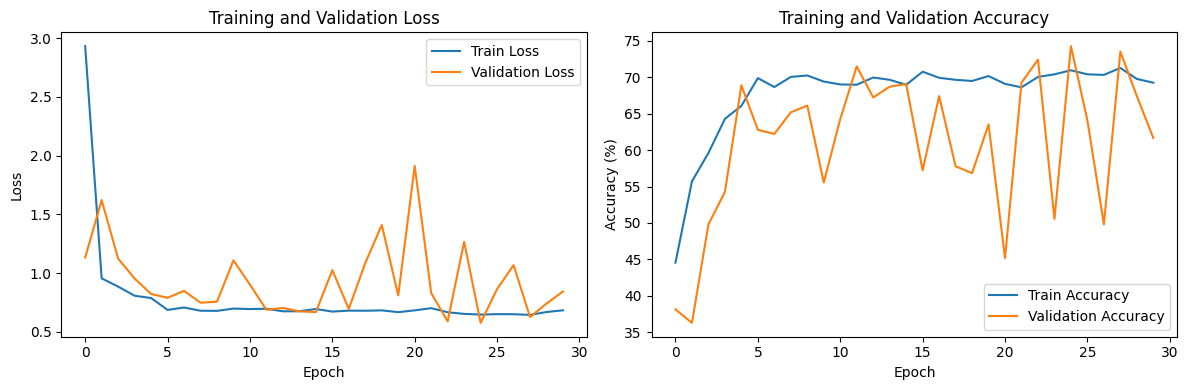

In [166]:

# Plot training results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [167]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 0.61
Confusion Matrix:


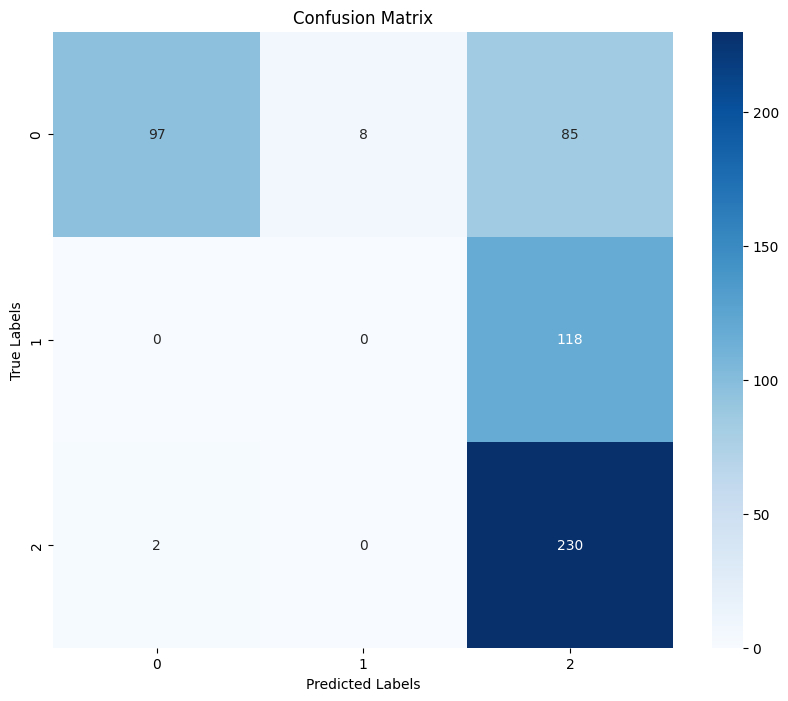

In [168]:
# Inference script to test test_loader
def run_inference(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)
    softmax = nn.Softmax(dim=1)

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probabilities = softmax(outputs)
            _, preds = torch.max(probabilities, 1)

            # Collect labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate and display the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


run_inference(model,test_loader,device)